In [1]:
import numpy as np
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn

(466, 637, 4)
(466, 637, 4)


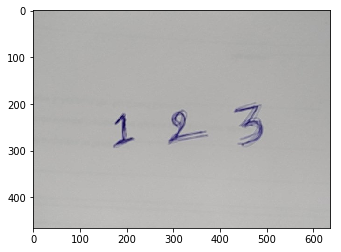

In [2]:
im = io.imread('./image.png')
print im.shape
num=np.array(im)
print im.shape

plt.imshow(im)

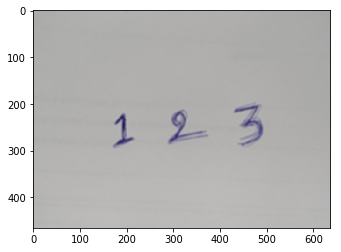

In [3]:
img = cv2.GaussianBlur(im, (5, 5), 100)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#sv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.figure(0)
plt.imshow(img)

In [4]:
th = 255 - cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#plt.imshow(th, cmap='gray')

In [5]:
kim = th.copy()
#plt.imshow(kim,cmap='gray')

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


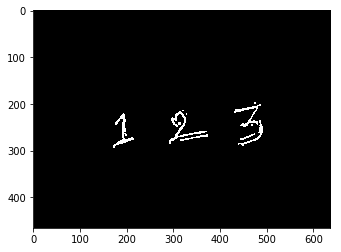

In [6]:
kernel = np.ones((3, 3)) / 9.0
print kernel

a = cv2.dilate(kim, kernel, iterations=1)
a = cv2.erode(a, kernel, iterations=1)
a = cv2.morphologyEx(a, cv2.MORPH_OPEN, kernel)
a = cv2.morphologyEx(a, cv2.MORPH_CLOSE, kernel)

plt.imshow(a,cmap='gray')

11


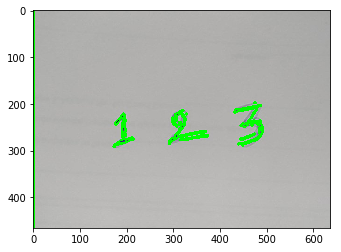

In [7]:
cnts, _= cv2.findContours(a, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=lambda x: cv2.contourArea(x))
print len(cnts)

zxzx = im[:, :, :3].copy()
cv2.drawContours(zxzx, cnts, -1, (0,255,0), 3)

plt.imshow(zxzx)

(466, 637, 3) 0.0
613.5 (171, 221, 45, 73)
(28, 28)
727.5 (290, 216, 81, 71)
(28, 28)
821.0 (430, 202, 61, 88)
(28, 28)


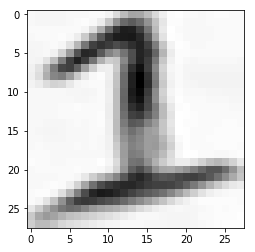

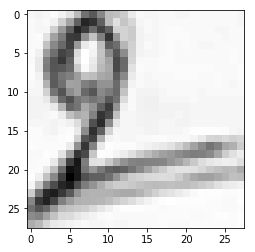

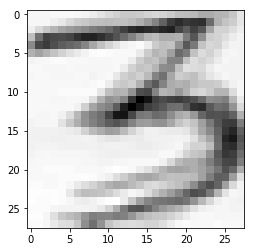

In [11]:
em = np.zeros(gray.shape + (3,), dtype=np.uint8)
print em.shape, em.mean()
kk = 0

numar=[]
for ix in cnts:
    if cv2.contourArea(ix) > 500:
        print cv2.contourArea(ix), cv2.boundingRect(ix)
        x, y, w, h = cv2.boundingRect(ix)
        if np.abs(w-h) < 150:
            
            plt.figure(kk)
            section = gray[y:y+h, x:x+w]
            section = cv2.resize(section, (28,28))
            plt.imshow(section, cmap='gray')
            numar.append(section)
#             plt.savefig()
#             book+=1
            print section.shape
            kk += 1
            cv2.drawContours(em, [ix], -1, (0, 255, 0), 3)

# plt.imshow(em)
# .
# 192221779

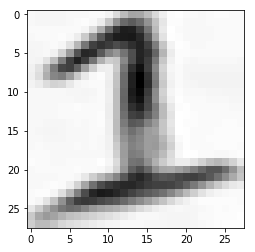

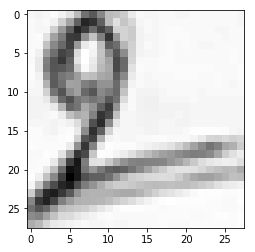

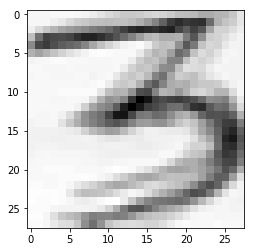

ValueError: Expected 1D or 2D array, got 3D array instead

In [13]:
numar


for i,ix in zip(range(len(numar)),numar):
    plt.figure(i)
    plt.imshow(ix.reshape((28,28)),cmap='gray')
    plt.show()
    
numar=np.asarray(numar)
np.savetxt("extractedNumbers.csv", numar, delimiter=",")

In [ ]:

ds = pd.read_csv('../../data/mnist/train.csv').values
print ds.shape

In [ ]:
# Data Preparation
X_train = ds[:10000, 1:].reshape((-1, 1, 28, 28)) / 255.0
y_train = ds[:10000, 0]

X_test = pd.read_csv('../../')
y_test = ds[5000:5100, 0]
# y_train = one_hot(y_train_labels, 10)

print X_train.shape, y_train.shape

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = F.softmax(self.out(x))
        return output

In [ ]:
cnn = CNN()
print cnn

#cnn.cuda()

In [ ]:
# SGD needs more (like x100 more!) learning rate.
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)   # optimize all cnn parameters
# TODO: Maybe add weight_decay parameter to the optimier?

loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted
type(loss_func)

In [ ]:
def make_batch(train, labels, batch_size=10, gpu=True):
    start = 0
    stop = start + batch_size
    while start < train.shape[0]:
        if gpu:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True).cuda(), Variable(torch.LongTensor(labels[start:stop])).cuda()
        else:
            yield Variable(torch.FloatTensor(train[start:stop]), requires_grad=True), Variable(torch.LongTensor(labels[start:stop]))
        start = stop
        stop = start + batch_size

In [ ]:
for epoch in range(25):
    for step, (b_x, b_y) in enumerate(make_batch(X_train, y_train, 10,False)):   # gives batch data, normalize x when iterate train_loader
        # print step,
        output = cnn(b_x)               # cnn output
        # print output.size(), output.sum(dim=0)
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        
        # for params in cnn.parameters():
        #     print params.grad.cpu().data.sum() # Y U no train!!!
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output = cnn(torch.FloatTensor(X_test))
            outs = test_output.cpu().data.numpy().argmax(axis=1)
            acc = (outs == y_test).sum()*100.0 / test_output.shape[0]
            # pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            # accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| Step: ', step, '| Acc: ', acc)

In [ ]:
outs = cnn(torch.FloatTensor(X_test))
print type(X_test)
print type(numar)

In [ ]:
((outs.data.numpy()).argmax(axis=1))[:10]

In [ ]:
for ix,i in zip(X_test,range(X_test.shape[0])):
    plt.figure(i)
    plt.imshow(ix.reshape((28,28)),cmap='gray')
    plt.show()

In [ ]:
outs = cnn(torch.FloatTensor(numar))